## Sentiment analysis for Youtube comments (English)

## 1. Import neccessary modules

In [26]:
!pip install autocorrect

  Using cached autocorrect-2.6.1.tar.gz (622 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=a5e6b90b57f4830dbbb158879e7ac3ab7f680696fb9f9b669c517af65030732b
  Stored in directory: /Users/macos/Library/Caches/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [21]:
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing, metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torchtext
import torchtext.transforms as T
import torchtext.functional as F
from torchtext.models import RobertaClassificationHead, XLMR_BASE_ENCODER



import nltk
from nltk.corpus import stopwords

## 2. Load and preprocessing data

In [22]:
df = pd.read_csv("../data/youtube_comments.csv")
df = df.sample(frac = 1)
df

,Comment,Label
484,Amazing tutorial! Thanks a lot!! You explain e...,2
319,Best algorithms channel on youtube.,2
409,This video was very helpful and in less time! ...,2
580,Nicee sir tq very much,2
799,"Just for you, I watch every video of this chan...",2
...,...,...
37,Thank You Sir...,2
1909,Doctors will be replaced by data science,1
2524,I failed at last question ðŸ˜¢,0
2402,Sorry!!! My issue is with Guess the Number (no...,0


<Axes: xlabel='Label', ylabel='count'>

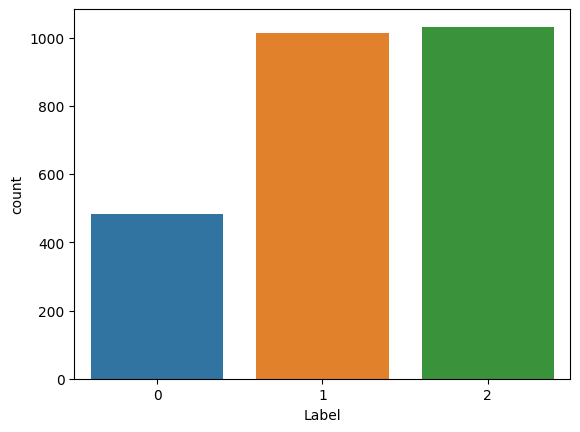

In [23]:
sns.countplot(x='Label', data=df)

In [24]:
# lowercasing
df['Comment'] = df['Comment'].str.lower()

# removing urls
df['Comment'] = df['Comment'].str.replace('http\S+|www.\S+', '', case=False)

# removing commas "\n"
df['Comment'] = df['Comment'].replace('\n','', regex=True)

# removing all the punctuations
df['Comment'] = df['Comment'].str.replace('[^\w\s]','')

# removing integers
#df['Comment'] = df['Comment'].replace('\d','', regex=True)

# removing emojis
#df['Comment'] = df['Comment'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

In [27]:
from autocorrect import Speller

spell = Speller(lang='en')

def typo_corrector(text):
    return spell(text)

df['Comment'] = df['Comment'].apply(typo_corrector)

In [28]:
# stemming
import nltk
stemmer = nltk.stem.SnowballStemmer('english')
def stem_text(text):
    return stemmer.stem(text)

df['Comment'] = df['Comment'].apply(stem_text)


# lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df['Comment'] = df['Comment'].apply(lemmatize_text)

In [29]:
# Removing stopwords
# nltk.download('stopwords')

stop = stopwords.words('english')

# These are the words that should not be removed from their category
negative_words = ['no','not']
neutral_words = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am',
                      'are','could','would','should','can','did','does','do','had','have']

for_negative_category = stop.copy()
for word in negative_words:
    if word in for_negative_category:
        for_negative_category.remove(word)
    
for_neutral_category = stop.copy()
for word in neutral_words:
    if word in for_neutral_category:
        for_neutral_category.remove(word)

# For negative category
for i in range(len(df)):
    if df["Label"][i] == "negative":
        df["Comment"][i] = ' '.join([word for word in df["Comment"][i].split() if word not in for_negative_category])

# For neutral category
for i in range(len(df)):
    if df["Label"][i] == "neutral":
        df["Comment"][i] = ' '.join([word for word in df["Comment"][i].split() if word not in for_neutral_category])
        
# For positive category
for i in range(len(df)):
    if df["Label"][i] == "positive":
        df["Comment"][i] = ' '.join([word for word in df["Comment"][i].split() if word not in stop])


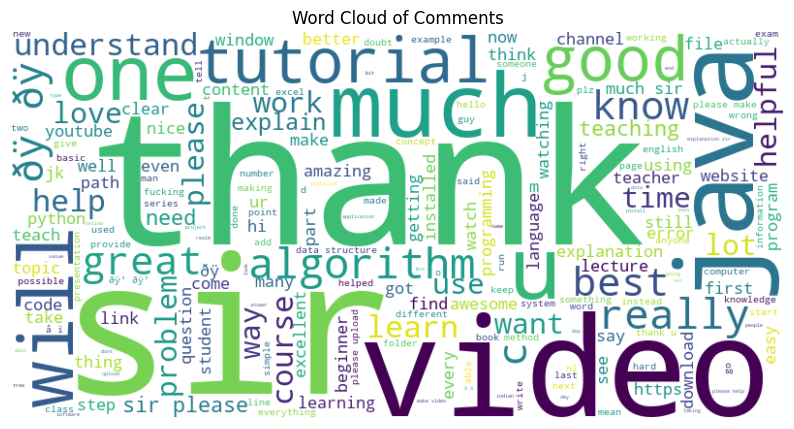

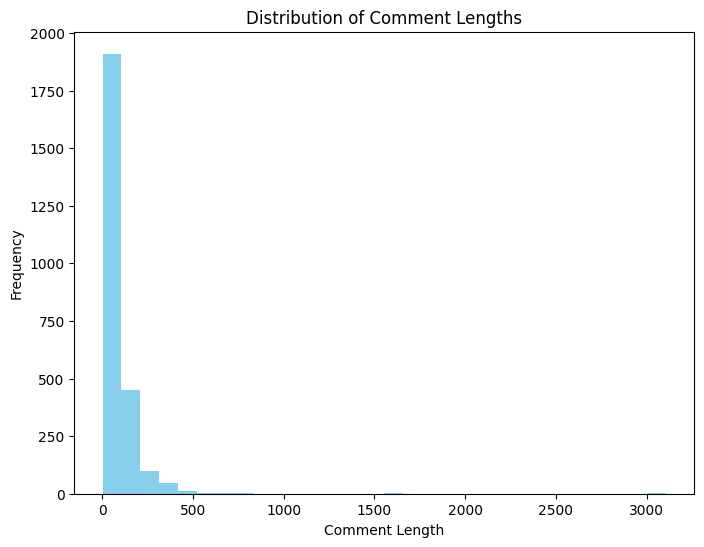

In [30]:
# Concatenate all comments into a single string
comments_text = ' '.join(df['Comment'].values)
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)
# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

# Histogram to visualize the length of comments
comment_lengths = df['Comment'].str.len()

plt.figure(figsize=(8, 6))
plt.hist(comment_lengths, bins=30, color='skyblue')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()


## 3. Train SKLearn models

In [31]:
X = df['Comment']
y = df["Label"]

In [33]:
flat_array = X.to_numpy()
flat_array = flat_array.flatten()
vectorizer = TfidfVectorizer (max_features=2500, min_df=0.0, max_df=0.8)
X_vectorized = vectorizer.fit_transform(flat_array)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=0)

In [35]:
# Initialize the classifiers
classifiers = {
    'LinearSVC': LinearSVC(C=1.0, random_state=0),
    'RandomForest': RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', random_state = 0),
    'LogisticRegression': LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0),
    'MultinomialNB': MultinomialNB(alpha=1, fit_prior=False),
    'DecisionTree': DecisionTreeClassifier(criterion='gini', max_features=None,min_samples_leaf=1,min_samples_split=2, random_state=0)
}

# Train and evaluate each model
accuracies = {}
predictions = {}

for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)
    predictions[name] = y_pred.astype(str)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


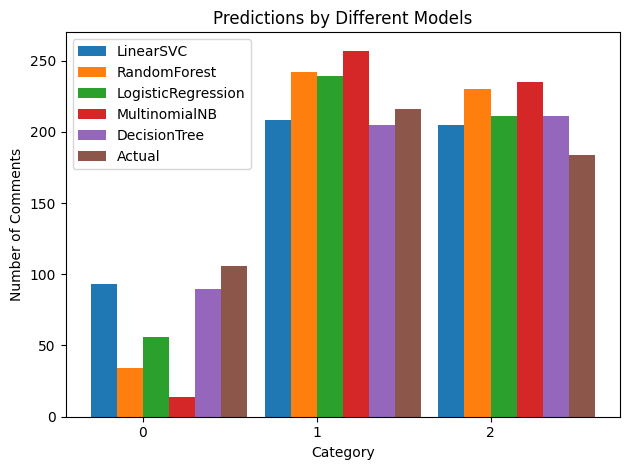

In [36]:
# Get the counts of each category in y_test
unique_labels = np.unique(y_test)
actual_counts = np.bincount(y_test.astype(int), minlength=len(unique_labels))

# Plot the number of comments predicted in each category for all models
categories = ['0', '1', '2']
num_models = len(classifiers)
bar_width = 0.15
index = np.arange(len(categories))
offset = bar_width * ((num_models + 1) / 2)

plt.figure()

# Plot the predictions of each model
for i, (name, preds) in enumerate(predictions.items()):
    counts = np.zeros((len(categories),))
    for j, category in enumerate(categories):
        counts[j] = np.sum(preds == category)
    plt.bar(index + (i * bar_width) - offset, counts, bar_width, label=name)

# Plot the actual counts
plt.bar(index + (num_models * bar_width) - offset, actual_counts, bar_width, label='Actual')

plt.xlabel('Category')
plt.ylabel('Number of Comments')
plt.title('Predictions by Different Models')
plt.xticks(index - (offset / 2), unique_labels)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
# Print the accuracies
for name, accuracy in accuracies.items():
    print(f'{name} Accuracy: {accuracy}')

LinearSVC Accuracy: 0.8221343873517787
RandomForest Accuracy: 0.7470355731225297
LogisticRegression Accuracy: 0.8043478260869565
MultinomialNB Accuracy: 0.7252964426877471
DecisionTree Accuracy: 0.7055335968379447


In [42]:
# Print the F1 score
for name, preds in predictions.items():
    preds_str = preds.astype(str)  
    y_test_str = y_test.astype(str)
    f1 = f1_score(y_test_str, preds_str, average='macro')  # Change average as per your requirement
    print(f'{name} F1 Score: {f1}')

LinearSVC F1 Score: 0.8057118586741404
RandomForest F1 Score: 0.6813910712904447
LogisticRegression F1 Score: 0.7662286975929732
MultinomialNB F1 Score: 0.6020450663038219
DecisionTree F1 Score: 0.6792225438237472


## 4. Train RoBERTa model

In [18]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

<Axes: xlabel='Label', ylabel='count'>

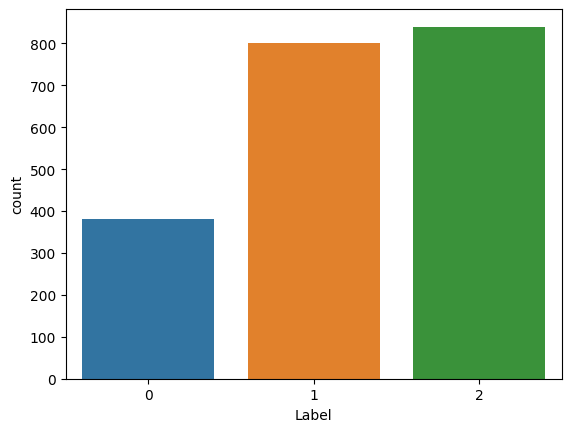

In [19]:
sns.countplot(x='Label', data=train_df)

<Axes: xlabel='Label', ylabel='count'>

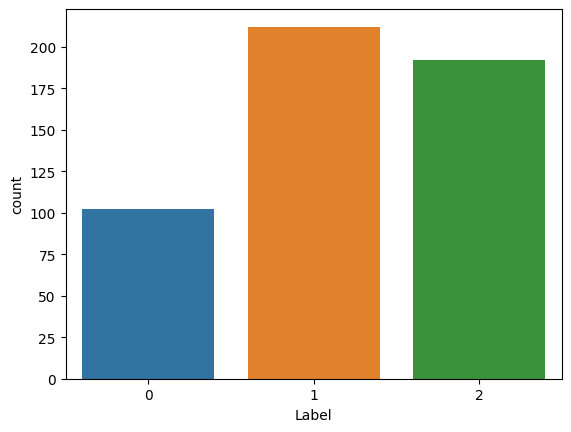

In [20]:
sns.countplot(x='Label', data=test_df)

In [21]:
label_encoder = preprocessing.LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])

In [22]:
class PadTransform(torch.nn.Module):
    """Pad tensor to a fixed length with given padding value.
    :param max_length: Maximum length to pad to
    :type max_length: int
    :param pad_value: Value to pad the tensor with
    :type pad_value: bool
    """

    def __init__(self, max_length: int, pad_value: int) -> None:
        super().__init__()
        self.max_length = max_length
        self.pad_value = float(pad_value)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        :param x: The tensor to pad
        :type x: Tensor
        :return: Tensor padded up to max_length with pad_value
        :rtype: Tensor
        """
        max_encoded_length = x.size(-1)
        if max_encoded_length < self.max_length:
            pad_amount = self.max_length - max_encoded_length
            x = torch.nn.functional.pad(x, (0, pad_amount), value=self.pad_value)
        return x

In [23]:
padding_idx = 1
bos_idx = 0
eos_idx = 2
max_seq_len = 256

text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()

In [24]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(text_transform(self.df.iloc[idx, 0])),
            torch.tensor(self.df.iloc[idx, 1])
        )

train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

In [25]:
SMALL_BATCH_SIZE = 16
LARGE_BATCH_SIZE = 32

In [26]:
def batch_collate_fn(batch):
    inp_list = list()
    tar_list = list()
    
    for sample in batch:
        inp_list.append(sample[0].tolist())
        tar_list.append(sample[1])
        
    padded_tensor = F.to_tensor(inp_list, padding_value=padding_idx)
    target_tensor = torch.stack(tar_list).type(torch.LongTensor)
    
    return padded_tensor, target_tensor

In [27]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=True,
    collate_fn=batch_collate_fn
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=False,
    collate_fn=batch_collate_fn
)

num_classes = 3
input_dim = 768

In [28]:
classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
model = XLMR_BASE_ENCODER.get_model(head=classifier_head)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(DEVICE)
pass  
learning_rate = 1.2e-5 
optim = AdamW(model.parameters(), lr=learning_rate)
criteria = torch.nn.CrossEntropyLoss()

### Train

In [29]:
def train_step(input, target, small_batch_no):
    output = model(input)
    loss = criteria(output, target)
    loss.backward()
    
    if (small_batch_no + 1) % K == 0 or (small_batch_no + 1) == len(train_dataloader):
        optim.step()
        optim.zero_grad()
    
    return loss.item() / input.size(dim=0)

def evaluate():
    model.eval()
    total_loss = 0
    counter = 0
    
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            input = batch[0].clone().detach().to(DEVICE)
            output = model(input)
            target = batch[1].clone().detach().to(DEVICE)
            
            if i == 0:
                class_output = torch.argmax(output, dim=1)
                class_target = target
            else:
                class_output = torch.cat([class_output, torch.argmax(output, dim=1)])
                class_target = torch.cat([class_target, target])
            
            loss = criteria(output, target).item()
            total_loss += loss
            counter += input.size(dim=0)
            
            
        confusion_matrix = metrics.confusion_matrix(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2]
        ) 
        classification_report = metrics.classification_report(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2],
            output_dict=True
        )

    return (
        total_loss,
        counter,
        confusion_matrix,
        classification_report
    )

In [30]:
num_epochs = 20

In [31]:
def save_log(epoch, **kwargs):
    with open(f'log_{epoch}.pkl', 'wb') as f:
        pickle.dump(kwargs, f)

def save_model(message):
    torch.save(model.state_dict(), f'model_{message}.pth')
    print('Model saved successfully')

In [32]:
max_accuracy = float('-inf')
max_macro_f1 = float('-inf')
max_weighted_f1 = float('-inf')

In [33]:
for epoch in range(num_epochs):
    model.train()
    avg_training_losses = list()
    
    for small_batch_no, small_batch in enumerate(train_dataloader):
        input = small_batch[0].clone().detach().to(DEVICE)
        target = small_batch[1].clone().detach().to(DEVICE)
        avg_training_losses.append(
            train_step(input, target, small_batch_no)
        )
        torch.cuda.empty_cache()

    total_loss, counter, confusion_matrix, classification_report = evaluate()
    print(f'EPOCH {epoch}')
    print(f'Mean of avg_training_losses={np.mean(avg_training_losses)}')
    print(f'total_loss={total_loss}')
    print(f'counter={counter}')
    print(f'loss=total_loss/counter={total_loss/counter}')
    print(f'confusion_matrix=\n{confusion_matrix}')
    print('classification_report=')
    pprint.pprint(classification_report)
    
    save_log(
        epoch,
        avg_training_losses=avg_training_losses,
        total_loss=total_loss,
        counter=counter,
        loss=total_loss/counter,
        confusion_matrix=confusion_matrix,
        classification_report=classification_report
    )
    
    if classification_report['accuracy'] > max_accuracy:
        print(f'New max_accuracy')
        max_accuracy = classification_report['accuracy']
        max_accuracy_index = epoch
        save_model('max_accuracy')
        
    elif classification_report['macro avg']['f1-score'] > max_macro_f1:
        print(f'New max_macro_f1')
        max_macro_f1 = classification_report['macro avg']['f1-score']
        max_macro_f1_index = epoch
        save_model('max_macro_f1')
    
    elif classification_report['weighted avg']['f1-score'] > max_weighted_f1:
        print(f'New max_weighted_f1')
        max_weighted_f1 = classification_report['weighted avg']['f1-score']
        max_weighted_f1_index = epoch
        save_model('max_weighted_f1')
    
    elif epoch == num_epochs - 1:
        save_model(f'{epoch}_last')
    
    elif epoch % 40 == 0:
        save_model(f'{epoch}_checkpoint')
        
    else:
        continue

save_log(
    'post_train_info',
    max_accuracy=max_accuracy,
    max_accuracy_index=max_accuracy_index,
    max_macro_f1=max_macro_f1,
    max_macro_f1_index=max_macro_f1_index,
    max_weighted_f1=max_weighted_f1,
    max_weighted_f1_index=max_weighted_f1_index
)

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:179.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

EPOCH 0
Mean of avg_training_losses=0.06556191019068554
total_loss=29.572609424591064
counter=506
loss=total_loss/counter=0.0584438921434606
confusion_matrix=
[[  0  42  60]
 [  0 145  67]
 [  0   5 187]]
classification_report=
{'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 102},
 '1': {'f1-score': 0.7178217821782179,
       'precision': 0.7552083333333334,
       'recall': 0.6839622641509434,
       'support': 212},
 '2': {'f1-score': 0.7391304347826088,
       'precision': 0.5955414012738853,
       'recall': 0.9739583333333334,
       'support': 192},
 'accuracy': 0.6561264822134387,
 'macro avg': {'f1-score': 0.4856507389869422,
               'precision': 0.4502499115357395,
               'recall': 0.5526401991614256,
               'support': 506},
 'weighted avg': {'f1-score': 0.58120802628467,
                  'precision': 0.5423875804570211,
                  'recall': 0.6561264822134387,
                  'support': 506}}
New max_accuracy
Model saved su

Model saved successfully
EPOCH 8
Mean of avg_training_losses=0.020406323547042377
total_loss=8.99282574467361
counter=506
loss=total_loss/counter=0.017772382894611877
confusion_matrix=
[[ 87  11   4]
 [  8 187  17]
 [  3  13 176]]
classification_report=
{'0': {'f1-score': 0.87,
       'precision': 0.8877551020408163,
       'recall': 0.8529411764705882,
       'support': 102},
 '1': {'f1-score': 0.8841607565011821,
       'precision': 0.8862559241706162,
       'recall': 0.8820754716981132,
       'support': 212},
 '2': {'f1-score': 0.9048843187660669,
       'precision': 0.8934010152284264,
       'recall': 0.9166666666666666,
       'support': 192},
 'accuracy': 0.8893280632411067,
 'macro avg': {'f1-score': 0.8863483584224164,
               'precision': 0.8891373471466196,
               'recall': 0.8838944382784559,
               'support': 506},
 'weighted avg': {'f1-score': 0.8891697027299119,
                  'precision': 0.8892693107829877,
                  'recall': 0.8893

EPOCH 16
Mean of avg_training_losses=0.008785064330903857
total_loss=10.551208809018135
counter=506
loss=total_loss/counter=0.020852191322170227
confusion_matrix=
[[ 92   8   2]
 [  8 193  11]
 [  5   9 178]]
classification_report=
{'0': {'f1-score': 0.888888888888889,
       'precision': 0.8761904761904762,
       'recall': 0.9019607843137255,
       'support': 102},
 '1': {'f1-score': 0.9146919431279621,
       'precision': 0.919047619047619,
       'recall': 0.910377358490566,
       'support': 212},
 '2': {'f1-score': 0.9295039164490861,
       'precision': 0.9319371727748691,
       'recall': 0.9270833333333334,
       'support': 192},
 'accuracy': 0.9150197628458498,
 'macro avg': {'f1-score': 0.9110282494886457,
               'precision': 0.909058422670988,
               'recall': 0.913140492045875,
               'support': 506},
 'weighted avg': {'f1-score': 0.9151108904506308,
                  'precision': 0.9152993300045428,
                  'recall': 0.9150197628458498,

In [34]:
max_accuracy
# max_accuracy_index
# max_macro_f1
# max_macro_f1_index
# max_weighted_f1
# max_weighted_f1_index

0.9150197628458498

### Predict

In [58]:
def prepare_model():
    num_classes = 3
    input_dim = 768

    classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
    model = XLMR_BASE_ENCODER.get_model(head=classifier_head)
    
    DEMO_MODEL_PATH = 'model_max_accuracy.pth'
    model.load_state_dict(torch.load(DEMO_MODEL_PATH))
    model.to(DEVICE)
    
    print(f'Loaded model to [{DEVICE}] in [{DEMO_MODEL_PATH}]')
    return model

def prepare_text_transform():
    text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()
    return text_transform

def predict(sentence, model, text_transform, label_map):
    transformed_text = text_transform(sentence)
    out = model(torch.tensor([transformed_text]).to(DEVICE))
    return label_map[torch.argmax(out).item()]

label_map = {
    0: 0,
    1: 1,
    2: 2
}

model = prepare_model()
text_transform = prepare_text_transform()

Loaded model to [cpu] in [model_max_accuracy.pth]


In [60]:
neg = 0
neu = 0
pos = 0

for index, row in test_df.iterrows():
    comment = row['Comment']
    actual_label = row['Label']
    prediction = predict(comment, model, text_transform, label_map)  
    if prediction != actual_label:
        print(comment)
        print(prediction)
        print(actual_label)
        print()

    if prediction == 0:
        neg = neg + 1
    elif prediction == 1:
        neu = neu + 1
    elif prediction == 2:
        pos = pos + 1


this video is absolutely phenomenon and unmistakably remarkable. #brilli
1
2

thanks man, now i'll be able to do my axonometric this week, just have to figure out how to change the units to metric :)
1
2

horribl
2
0

i want to download for remember heheh
1
2

every day moving planning for how i can get lana getting off her clothesjust for made the subscriber be happy and happy and happi
2
0

it is sentiment analysis, not sentimental :d
0
1

i am lost was this like if normal installation would not work?
1
0

since he is an indian he knows that how valuable is such type of high quality content and an amazing website is but still he is teaching for free :3 .
1
2

sir ab ky mlb...ab to human ada ka paper ho ga
1
2

how to take inputs at a time in python using a single line stat
1
2

applied to isufs , 296 gre 7.4 copa. got rejected.
1
0

what the f*** is *votes* ?ðÿ˜'ðÿ˜'ðÿ˜' i've been a programmer for 9 years! never heard of *votes* !!
1
0

hello sir i am one of ur student from van
1
2



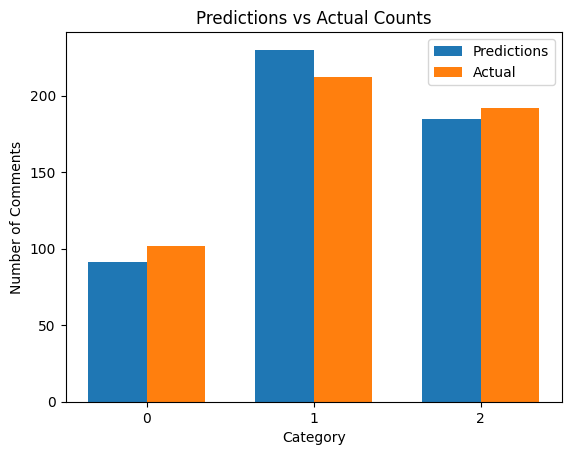

In [61]:
# Get the actual counts from the 'Label' column in `test_df`
actual_counts = test_df['Label'].value_counts().sort_index()

# Define the categories and their corresponding indices
categories = ['0', '1', '2']
indices = np.arange(len(categories))

# Set the width of each bar
bar_width = 0.35

# Plot the predictions and actual counts
plt.bar(indices, [neg, neu, pos], bar_width, label='Predictions')
plt.bar(indices + bar_width, actual_counts, bar_width, label='Actual')

# Add labels, title, and ticks
plt.xlabel('Category')
plt.ylabel('Number of Comments')
plt.title('Predictions vs Actual Counts')
plt.xticks(indices + bar_width/2, categories)
plt.legend()

# Display the graph
plt.show()

In [69]:
sample_text = 'Thanks for reading!!!'
predict(sample_text, model, text_transform, label_map)

2